In [22]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, PillowWriter

import ipywidgets as widgets
from PIL import Image

from torchvision.utils import save_image, make_grid

In [23]:
# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
def draw_data(data, title_str='Data'):
    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data[:,0], data[:,1], label='data', c='blue', alpha=1)
    # set a title and labels
    ax.set_title(title_str)

In [25]:
def draw_vector(points, vectors, title_str="vectors", lim=None, scale = 1):
    fig, ax = plt.subplots(figsize=(7, 7))

    x = points[:,0]
    y = points[:,1]
    x_v = vectors[:,0]
    y_v = vectors[:,1]

    plt.quiver(x, y, x_v, y_v, color="blue", angles='xy', scale_units='xy', scale=scale, alpha=.7)

    if lim is None:
        x_min = min(x.min(), (x + x_v).min())
        x_max = max(x.max(), (x + x_v).max())
        y_min = min(y.min(), (y + y_v).min())
        y_max = max(y.max(), (y + y_v).max())

        padding = .3
        plt.xlim(x_min - padding, x_max + padding)
        plt.ylim(y_min - padding, y_max + padding)
    else:
        plt.xlim(-lim, lim)
        plt.ylim(-lim, lim)

    ax.set_title(title_str)

    plt.grid()
    plt.show()

In [26]:
class diffuse(nn.Module):
    def __init__(self, n_steps=10, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(diffuse, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, data, t, eta=None):
        # x_0 -> x_t
        n, d = data.shape
        a_bar = self.alpha_bars[t-1]

        if eta is None:
            eta = torch.randn(n, d).to(self.device)

        noisy = a_bar.sqrt().view(-1,1) * data + (1 - a_bar).sqrt().view(-1,1) * eta

        # # x_t -> x_t+1
        # data = data.to(self.device)
        # n, d = data.shape
        # beta = self.betas[t].to(self.device)

        # if eta is None:
        #     eta = torch.randn(n, d).to(self.device)

        # noisy = (1-beta).sqrt().view(-1, 1) * data + beta.sqrt().view(-1, 1) * eta
        return noisy

In [27]:
class diffusive_flow(nn.Module):
    def __init__(self, t_range=200):
        super(diffusive_flow, self).__init__()
        self.t_range = t_range
        self.embedding = nn.Embedding(t_range, 1)
        
        self.fc = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
    
    def forward(self, data, t):
        N = data.size(0)
        t_tensor = torch.full((N, 1), t, dtype=torch.float)
        # embedded_t = self.embedding(t_tensor).squeeze(1)

        # embeddings_t = torch.ones((N, 1))
        # for i in range(N):
        #     embeddings_t[i] = self.embedding(torch.tensor(t))
        # print("embeddings_t: {}".format(embeddings_t))
        # embedded_t = self.embedding(torch.tensor(t))
        # expanded_t = embedded_t.unsqueeze(0).expand(data.size(0), -1)
        # embeddings_t = torch.tensor(embeddings_t)
        # concatenated = torch.cat((data, embeddings_t), dim=1)
        # print(embedded_t)
        # print(concatenated.shape)

        concatenated = torch.cat((data, t_tensor), dim=1)
        out = self.fc(concatenated)
        return out


In [28]:
# x_t에서의 velocity vector data 생성 (normalized vectors)
def make_vectors(diffuse, data, t):
    data = data.to(device)
    eta = torch.randn_like(data).to(device)

    noisy_data = diffuse(data, t, eta).to(device)
    v = noisy_data - data

    return noisy_data, v

In [29]:
def training_model(epochs, data, diffuse, m, device):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(m.parameters(), lr=0.00001)
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        t = random.randint(0, m.t_range-1)

        noisy_data, v = make_vectors(diffuse, data, t)
        v_pred = m(data, t)

        loss = criterion(v_pred.to(device), v.to(device))

        if epoch % 100 == 0:
            print("epoch: {}, loss: {}".format(epoch, loss.item()))
        
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
    
    return losses

# Data1

In [30]:
# data 생성
# generate a Gaussian data
dim = 2
datanum = 500
mean = np.array([0, 0])
cov = np.array([[.1,.01],[.01,.1]])

data1 = np.random.multivariate_normal(mean, cov, datanum)
data1 = torch.from_numpy(data1).float()

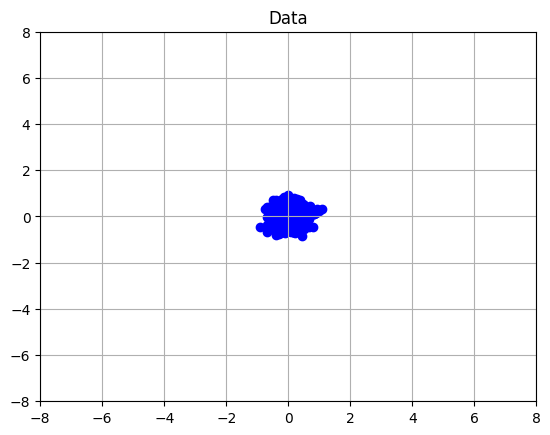

In [31]:
draw_data(data1.cpu(), title_str='Data')
lim = 8
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.grid(True)

In [32]:
# Definin model
t_range = 200
m = diffusive_flow(t_range=t_range)

In [33]:
# Defining diffuse
n_steps, min_beta, max_beta = t_range, 10 ** -4, 0.02

d = diffuse(n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [34]:
# training model
epochs = 700

losses = training_model(epochs, data1, d, m, device)

epoch: 0, loss: 0.7002058625221252
epoch: 100, loss: 0.742007851600647
epoch: 200, loss: 0.5326608419418335
epoch: 300, loss: 0.23183830082416534
epoch: 400, loss: 0.21814222633838654
epoch: 500, loss: 0.005348983686417341
epoch: 600, loss: 0.8738189935684204


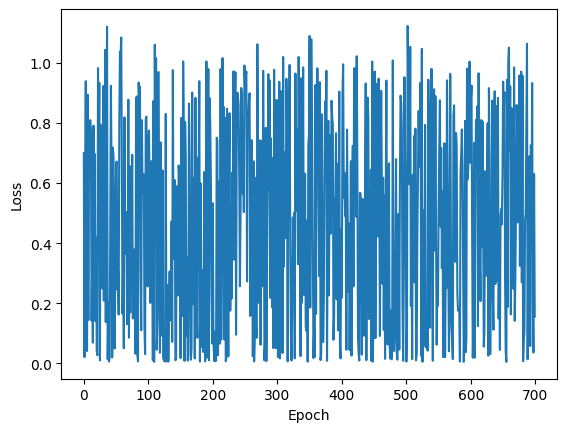

Final loss: 0.15537744760513306


In [35]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
print("Final loss: {}".format( losses[-1]))

In [36]:
# MyModel prediction - training_model_2 결과
t_slider = widgets.IntSlider(value=0, min=1, max=d.n_steps-1, step=10, description='t')
def update(t):
    with torch.no_grad():
        outputs = m(data1, t)
        draw_vector(data1.cpu(), outputs.cpu(), lim=1.)
        
widgets.interact(update, t=t_slider)

interactive(children=(IntSlider(value=1, description='t', max=199, min=1, step=10), Output()), _dom_classes=('…

<function __main__.update(t)>

In [46]:
# MyModel prediction - training_model_2 결과
t_slider = widgets.IntSlider(value=0, min=1, max=d.n_steps-1, step=10, description='t')
def update(t):
    with torch.no_grad():
        _,v = make_vectors(d, data1, t)
        draw_vector(data1.cpu(), v.cpu(), lim=3)
        print(outputs.norm().mean())
        
widgets.interact(update, t=t_slider)

interactive(children=(IntSlider(value=1, description='t', max=199, min=1, step=10), Output()), _dom_classes=('…

<function __main__.update(t)>

In [38]:
# # 플롯 초기화
# fig, ax = plt.subplots()

# # 업데이트 함수 정의
# def update(t):
#     ax.clear()
#     noisy = d(data1.to(device), t).cpu()
#     ax.scatter(noisy[:,0], noisy[:,1], label='data', c='blue', alpha=1)
#     ax.set_xlim(-5, 5)  # x축 범위 설정
#     ax.set_ylim(-5, 5)  # y축 범위 설정

# # 초기 프레임 설정
# def init():
#     ax.clear()
#     ax.scatter([], [])
#     ax.set_xlim(-5, 5)  # x축 범위 설정
#     ax.set_ylim(-5, 5)  # y축 범위 설정

# # 애니메이션 생성
# ani = FuncAnimation(fig, update, frames=range(200), init_func=init, repeat=False)

# # 프레임 이미지를 GIF로 저장
# ani.save('animated_diffuse.gif', writer=PillowWriter(fps=5))
# # 저장된 GIF 확인
# print("애니메이션 GIF가 'animated_plot.gif'로 저장되었습니다.")


# Draw vector field

In [39]:
def make_vector_field(grid_points, data, vectors, radius=.3):
    grid_points = grid_points.cpu()
    data = data.cpu()

    vector_field = torch.zeros_like(grid_points)

    for i, point in enumerate(grid_points):
        distances = torch.norm(data-point, dim=1)
        mask = (distances <= radius)
        neighbor_vs = vectors[mask]

        if neighbor_vs.size(0) > 0:
            vector_field[i] = neighbor_vs.mean(dim=0)
    
    # vector_field = normalize_vector_field(vector_field)

    return vector_field

In [40]:
# 격자 점 생성
x = torch.linspace(-5, 5, 32)
y = torch.linspace(-5, 5, 32)
X, Y = torch.meshgrid(x, y)
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1)

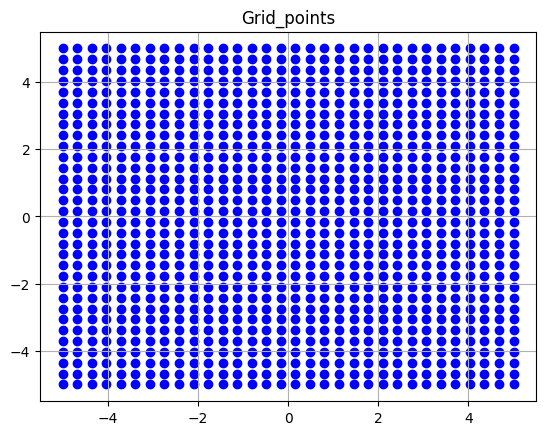

In [41]:
draw_data(grid_points.cpu(), title_str='Grid_points')
plt.grid(True)

In [42]:
t_slider = widgets.IntSlider(value=0, min=1, max=d.n_steps-1, step=10, description='t')
def update(t):
    with torch.no_grad():
        v = m(data1, t)
        vf = make_vector_field(grid_points.cpu(), data1.cpu(), v.cpu())
        draw_vector(grid_points.cpu(), vf.cpu())
        
widgets.interact(update, t=t_slider)

interactive(children=(IntSlider(value=1, description='t', max=199, min=1, step=10), Output()), _dom_classes=('…

<function __main__.update(t)>